In [21]:
"""
chapter 05
"""

# import libs 

import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from sklearn.datasets import make_moons, make_circles  

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from utils import *
from rbf_kernel_pca import *

In [2]:
# import dataset 
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


Eigenvalues: [ 4.8923083   2.46635032  1.42809973  1.01233462  0.84906459  0.60181514
  0.52251546  0.08414846  0.33051429  0.29595018  0.16831254  0.21432212
  0.2399553 ]


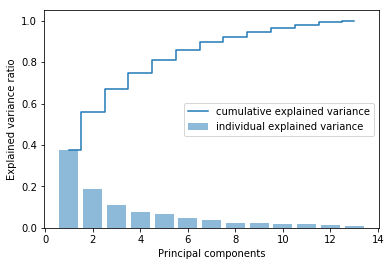

In [3]:
# ------------------ PCA --------------------------
# PCA 1: standardize the  d -dimensional dataset
sc = StandardScaler()  # need to standardize the features prior to PCA
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

# PCA 2: construct the covariance matrix
cov_mat = np.cov(X_train_std.T)

# PCA 3: decompose the covariance matrix into its eigenvectors and eigenvalues
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('Eigenvalues:', eigen_vals)  # 13 features --> 13x13 dimensional matrix 

# variance explained ratio: the fraction of an eigenvalue and the total sum of the eigenvalues 
tot = sum(eigen_vals)  # the total sum of the eigenvalues
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]  # vairance explained ratio
# cumulative sum of explained variances 
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1,14), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,14), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

# the first principal component --> 40% of the variance 
# the first two principla components --> 60% of the variance  

In [4]:
# PCA 4: select **k** eigenvectors that correspond to the **k** largest eigenvalues 
# --> **k**: the dimensionality of the new feature subspace (k<=d)  

# sort the eigenpairs by decreasing order of the eigenvalues 
eigen_pairs =[(np.abs(eigen_vals[i]),eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(reverse=True)

# PCA 5. construct a projection matrix **w** from the top **k** eigenvectors  
# collect the two eigenvectors that correspond to the two largest values to 
# capture about 60 percent of the variance in this dataset
w= np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n',w)

Matrix W:
 [[ 0.14669811  0.50417079]
 [-0.24224554  0.24216889]
 [-0.02993442  0.28698484]
 [-0.25519002 -0.06468718]
 [ 0.12079772  0.22995385]
 [ 0.38934455  0.09363991]
 [ 0.42326486  0.01088622]
 [-0.30634956  0.01870216]
 [ 0.30572219  0.03040352]
 [-0.09869191  0.54527081]
 [ 0.30032535 -0.27924322]
 [ 0.36821154 -0.174365  ]
 [ 0.29259713  0.36315461]]


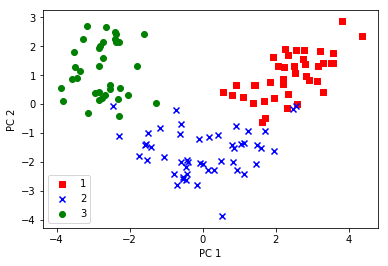

In [5]:
# PCA 6. transform the **d**-dimensional input dataset X 
# using the projection matrix **W** to obtain the new k-dimensional feature subspace  
# x' = x*W
X_train_pca = X_train_std.dot(w)

# visualize the transformed training set
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], X_train_pca[y_train==l, 1], c=c, label=l, marker=m) 
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

# the data is more spread along the x-axis—the first principal component [40%]
# than the second principal component (y-axis) [20%]

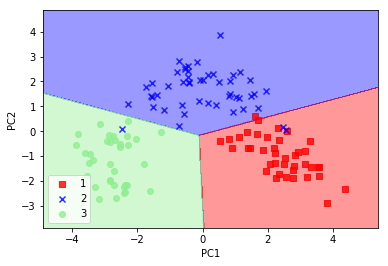

In [6]:
# use the PCA class implemented in scikit-learn 
pca = PCA(n_components=2)  # use top 2 features 
lr = LogisticRegression()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.show()

# the decision regions for the training model reduced 
# to the two principal component axes

In [7]:
# get the explained variance rations of the different principla components 
# set n_components parameter set to None, 
# so all principal components are kept and the explained variance ratio can 
# then be accessed via the explained_variance_ratio_ attribute
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_  
# return all principal components in sorted order instead of performing a dimensionality reduction.

array([ 0.37329648,  0.18818926,  0.10896791,  0.07724389,  0.06478595,
        0.04592014,  0.03986936,  0.02521914,  0.02258181,  0.01830924,
        0.01635336,  0.01284271,  0.00642076])

In [8]:

# ----------------- LDA (linear discriminant analysis) --------------

# LDA 1: standardize the features 
# LDA 2: for each class, compute the ```d```-dimensional mean vector
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1, 4):  # 3 classes in the dataset 
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('the mean vector: ', 'label:', label, mean_vecs[label-1])

the mean vector:  label: 1 [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]
the mean vector:  label: 2 [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]
the mean vector:  label: 3 [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]


In [9]:
# LDA 3: construct the between-class scatter matrix ```Sb``` and the within-class scatter matrix ```Sw``` 

# between-class scatter matrix: 
d = 13  # number of features 
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X[y == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row-mv).dot((row-mv).T)  # individual scatter matrices 
    S_W += class_scatter 
print('within-class scatter matrix: ', S_W.shape[0], 'x', S_W.shape[1])    


print('Class label distribution: %s' % np.bincount(y_train)[1:])

# scaled within-class scatter matrix:
# training set are not uniformly distributed --> need to scale the individual scatter matrices  
d = 13 # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
print('Scaled within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))
# print(S_W)


within-class scatter matrix:  13 x 13
Class label distribution: [40 49 35]
Scaled within-class scatter matrix: 13x13


In [10]:
# calculate between-class scatter matrix 
mean_overall = np.mean(X_train_std, axis=0)
d = 13  # number of features  
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X[y==i+1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)    
print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


In [11]:
# LDA 4: compute the eigenvectors and corresponding eigenvalues of the matrix ```(Sw)^(-1)*(Sb)```
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
# sort the eigenvalues in descending order
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print('Eigenvalues in decreasing order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in decreasing order:

370.011096511
4.88771327595e-14
3.08617480974e-14
3.08617480974e-14
1.23164413777e-14
1.23164413777e-14
1.0907897967e-14
1.0907897967e-14
1.02518851998e-14
2.87253034281e-15
2.87253034281e-15
1.80290685396e-16
0.0


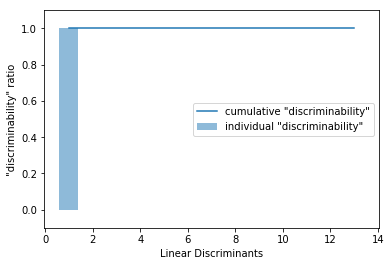

In [12]:
# plot the result 

tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid', label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.show()

In [13]:
# LDA 5:
# choose the k eigenvectors that correspond to the ```k``` largest eigenvalues to construct a ```d x k``` -dimensional transformation matrix ```W``` ; 
# the eigenvectors are the columns of this matrix  
# stack the two most discriminative eigenvector columns to create the transformation matrix W
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[ -1.0232e-02   9.3668e-02]
 [ -8.2253e-02  -1.9741e-01]
 [ -5.4586e-02   1.1653e-01]
 [ -1.2202e-01  -1.9147e-01]
 [  6.2223e-03  -4.4948e-02]
 [ -2.2569e-01   2.7410e-02]
 [  8.0438e-01  -6.9596e-01]
 [  9.4241e-02  -1.4724e-01]
 [ -5.0827e-02  -1.9922e-02]
 [ -2.3984e-01  -6.1882e-01]
 [  1.1217e-01   2.0544e-02]
 [  3.9136e-01  -9.7203e-02]
 [  2.0624e-01  -1.1406e-04]]


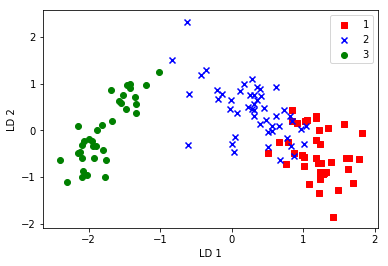

In [14]:
# LDA 6:
# project the samples onto the new feature subspace using the transformation matrix ```W```
# x' = xW
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0], X_train_lda[y_train==l, 1], c=c, label=l, marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='upper right')
plt.show()

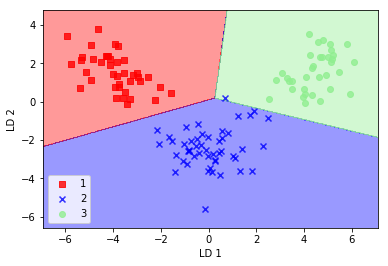

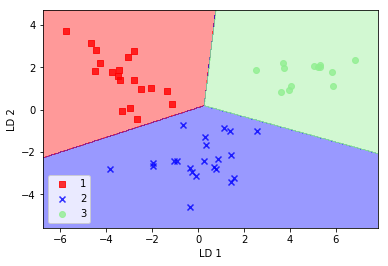

In [15]:
# LDA via scikit-learn 
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)
# how the logistic regression classifier handles the lower-dimensional 
# training dataset after the LDA transformation
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()

# lowering the regularization strength, shift the decision boundaries 
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()

half-moon shapes: 


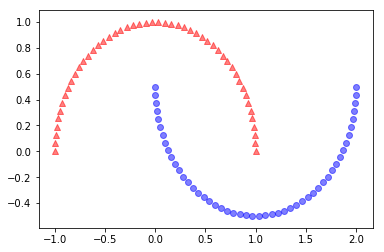

standard PCA:


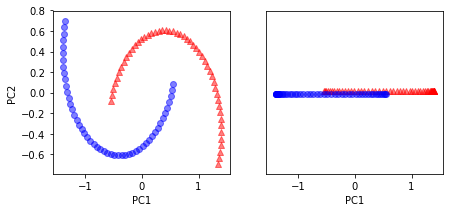

kernel PCA:


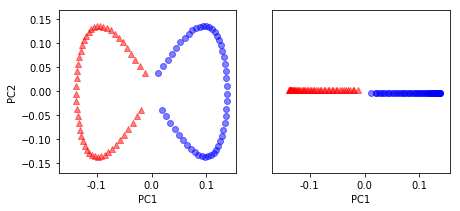

In [16]:
# ------------------------ kernel PCA -----------------------  
# apply rbf_kernel_pca on non-linear datasets

# example 1: separating half-moon shapes 
# import data: not linearly separable 
X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5)
print("half-moon shapes: ")
plt.show()

# project it onto the principal components via standard PCA
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_spca[y==0, 0], np.zeros((50,1))+0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==1, 0], np.zeros((50,1))-0.02, color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
print("standard PCA:")
plt.show()

# kernel PCA 
X_kpca , _ = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((50,1))+0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50,1))-0.02, color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
print('kernel PCA:')
plt.show()

concentric circles: 


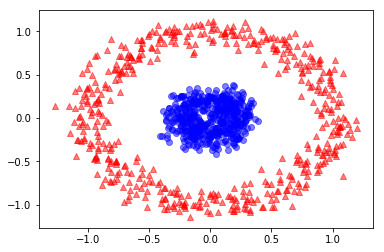

standard PCA:


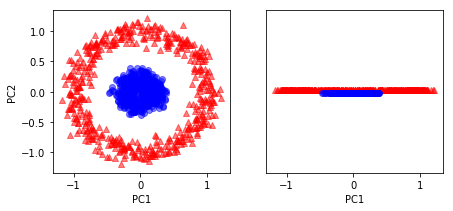

RBF kernel PCA: 


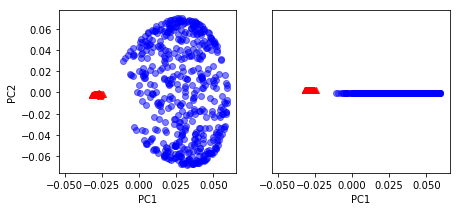

In [17]:
# example 2: separating concentric circles 

# import the data 
X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5)
print('concentric circles: ')
plt.show()

# standard PCA 
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_spca[y==0, 0], np.zeros((500,1))+0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==1, 0], np.zeros((500,1))-0.02, color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
print('standard PCA:')
plt.show()


# RBF kernel PCA 
X_kpca, _ = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((500,1))+0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((500,1))-0.02, color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
print('RBF kernel PCA: ')
plt.show()

original projection: [ 0.0788]
reproduce the original projection: [ 0.0788]


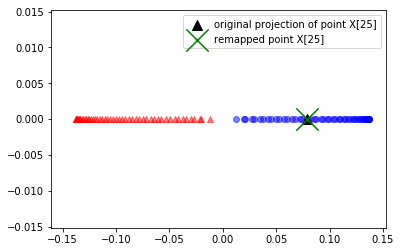

In [20]:
# project data points that were not part of the training dataset 

def project_x(x_new, X, gamma, alphas, lambdas):
    """
    project new data samples 
    """
    pair_dist = np.array([np.sum((x_new-row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)


# create a new half-moon dataset 
# project it onto a one-dimensional subspace using the RBF kernel PCA implementation 
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

# create a new data point 
x_new = X[25]
x_proj = alphas[25]  # original projection
print('original projection:', x_proj)

# reproduce the original projection
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
print('reproduce the original projection:', x_reproj)

# visualize the projection on the first principla component 
plt.scatter(alphas[y==0, 0], np.zeros((50)), color='red', marker='^',alpha=0.5)
plt.scatter(alphas[y==1, 0], np.zeros((50)), color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black', label='original projection of point X[25]', marker='^', s=100)
plt.scatter(x_reproj, 0, color='green', label='remapped point X[25]', marker='x', s=500)
plt.legend(scatterpoints=1)
plt.show()

# mapped the sample x' onto the first principla component correctly 

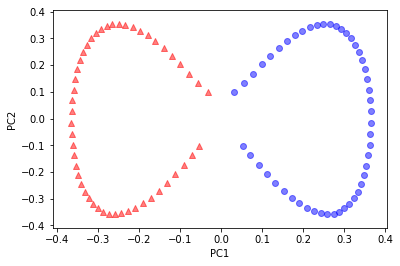

In [22]:
# kernel principla component analysis in scikit-learn 
X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y==0, 0], X_skernpca[y==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y==1, 0], X_skernpca[y==1, 1], color='blue', marker='o', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()